In [1]:
"""
@Josh Boquiren
Ver. II
OTIS Lab MUSC
9.27.2022

==========

Purpose:
 - Handles 3-Dimensional NPY arrays. Calculates the averages across the Z-axis (typically frames across time)
 - Averages the NPYs together, accounting for NaN values
 - Plots
 - Path format should look like:
    - parent dir
        - conditions
                - FOVs
                    - ROIs
Notes:
 - If there are any empyt folders, it may not work. Also folders must be specifically organized.
 - Primarily utilizes numpy modules; may need to develop new version for data sizes greater than 5000 using pandas
"""

'\n@Josh Boquiren\nVer. II\nOTIS Lab MUSC\n9.27.2022\n\n==========\n\nPurpose:\n - Loop through folders starting from a parent directory. Handles 3-Dimensional NPY arrays. Calculates the averages\nacross the Z-axis (typically frames across time), then averages the NPYs together, accounting for NaN values, and plots.\n\nNotes:\n - If there are any empyt folders, it may not work. Also folders must be specifically organized.\n - Primarily utilizes numpy modules; may need to develop new version for data sizes greater than 5000 using pandas\n'

In [2]:
#Import Libraries

import os #functions on the system
import numpy as np #functions on arrays
import pandas as pd #functions on DataFrames
import matplotlib.pyplot as plt #plot functions
import seaborn as sns #more plot functions
from scipy.stats import sem #statistic functions
import random #random generator 

In [3]:
"Functions"

#averages frames across time in individual ROIs, strips baseline
def ROI_avg_frame(NPY_file, baseline_start, baseline_end, cutoff_val):
    stripped_avg = []
    NPY_file = np.squeeze(NPY_file)
    avgd_frames = NPY_file.mean(axis=0)
    baseline = avgd_frames[baseline_start:baseline_end].mean()
    for frame in avgd_frames:
        stripped_frame = frame - baseline
        if stripped_frame < cutoff_val:
            stripped_avg.append(stripped_frame)
    return(np.array(stripped_avg))

In [4]:
"Loop through folders"

#parent_dir must be of format: parent->conditions->FOVs->ROIs, spaces typed or left in prompt matter
PARENT_DIR = input(">>> Enter parent directory file path containing conditions: ") 
baseline_start = int(input(">>> Enter beginning frame interger for baseline (MUST BE AN INTERGER): "))
baseline_end = int(input(">>> Enter ending frame interger for baseline (MUST BE AN INTERGER): "))
cutoff = float(input(">>> Enter an interger for a cut-off value (use for light artifacts - recommend 1): "))

DATA = [] #final storage space for processed data
for CONDITION in os.listdir(PARENT_DIR): #loops through conditions
    condition_avg_frames = []
    for FOV in os.listdir(os.path.join(PARENT_DIR, CONDITION)): #loops through FOVs
        fov_avg_frames = []
        for NPY in os.listdir(os.path.join(PARENT_DIR, CONDITION, FOV)): #loops through each ROI
            if os.path.exists(os.path.join(PARENT_DIR, CONDITION, FOV, NPY)):
                ROI = np.load(os.path.join(PARENT_DIR, CONDITION, FOV, NPY)) #loads in ROI NPY files
                fov_avg_frames.append(ROI_avg_frame(ROI, baseline_start, baseline_end, cutoff)) #calls function to process ROI
        fov_avg_frames = np.array(fov_avg_frames) 
        condition_avg_frames.append(fov_avg_frames.mean(axis=0)) #averages the ROIs in each FOV together
    condition_avg_frames = np.array(condition_avg_frames)
    condition_data = condition_avg_frames.mean(axis=0)
    st_dev = np.std(condition_data)
    DATA.append({"CONDITION": CONDITION, "DATA": condition_data}) #averages the FOVs together; saved as dictionary
DATA = np.array(DATA) #convert list to np.array for faster processing


>>> Enter parent directory file path containing conditions: C:\Users\jboqu\OneDrive\Desktop\OTIS_Lab\Projects\PvtChrimson-AstroGC\Data
>>> Enter beginning frame interger for baseline (MUST BE AN INTERGER): 0
>>> Enter ending frame interger for baseline (MUST BE AN INTERGER): 400
>>> Enter an interger for a cut-off value (use for light artifacts - recommend 1): 1


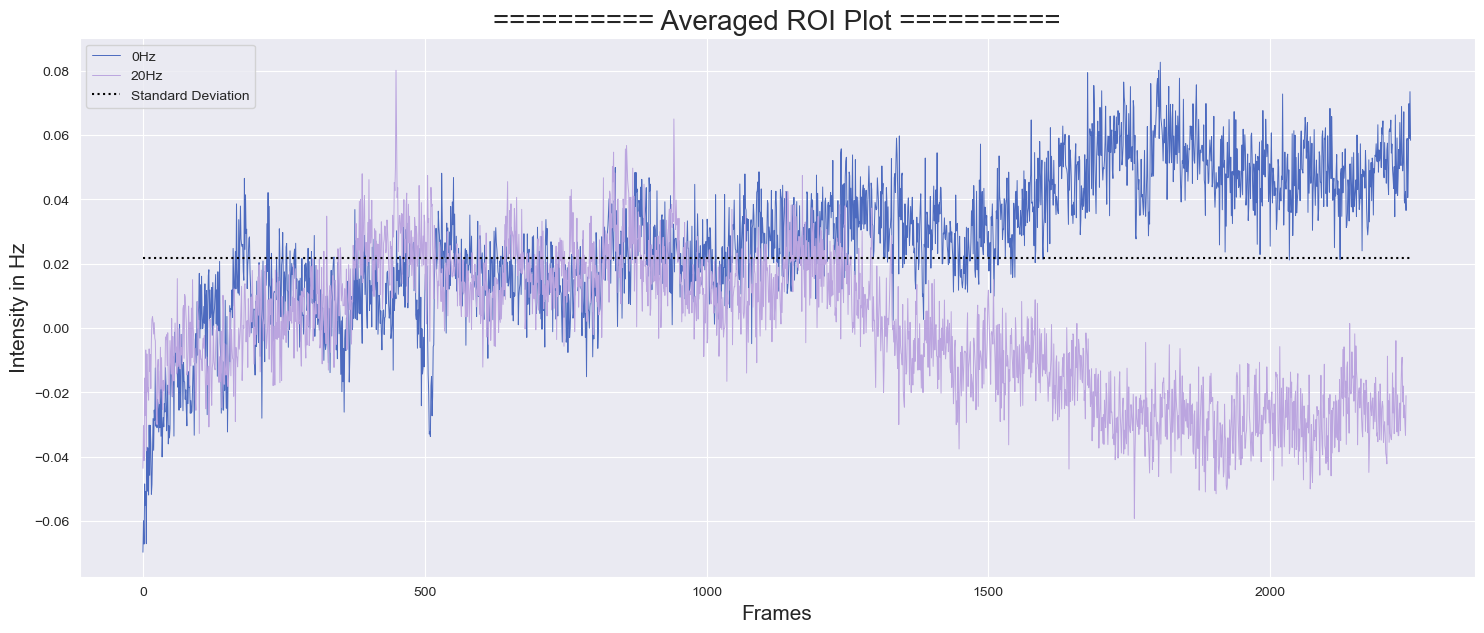

In [9]:
"Make plots"

from pyparsing import line


plt.figure(figsize=(18,7))
for i in DATA:
    r = random.random() #for random colors, cause why not?
    g = random.random()
    b = random.random()
    color = (r,g,b)
    sns.set_style("darkgrid")
    plt.plot(i["DATA"], color=color, lw=.7, label=i["CONDITION"])
plt.hlines(st_dev, 0, 2250, color="black", linestyles="dotted", label="Standard Deviation")
plt.legend()
plt.title("========== Averaged ROI Plot ==========", fontsize=20)
plt.xlabel("Frames", fontsize=15)
plt.ylabel("Intensity in Hz", fontsize=15)
plt.show()